In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def cmu_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1):
  x = input_layer
  for cnn_num in range(num_cnn):
    if cnn_num==1:
      x = layers.BatchNormalization()(x)
      identity = x
      identity = layers.Conv2D(x_channel, kernel_size=(1, 1), strides=(2, 2), padding="same")(identity)
      x = layers.Conv2D(filters=channel, kernel_size=(1,1),strides=(2,2), activation='elu', kernel_initializer='he_normal', padding='valid')(x)#,kernel_regularizer = tf.keras.regularizers.l2(0.0001)
      x = layers.BatchNormalization()(x)
      x = layers.Conv2D(filters=channel, kernel_size=(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)#,kernel_regularizer = tf.keras.regularizers.l2(0.001
      x = layers.BatchNormalization()(x)
      x = layers.Conv2D(filters=channel, kernel_size=(1,1), activation='elu', kernel_initializer='he_normal', padding='valid')(x)#,kernel_regularizer = tf.keras.regularizers.l2(0.001


    else:
      identity = x
      x = layers.BatchNormalization()(x)
      x = layers.Conv2D(filters=channel, kernel_size=(1,1), activation='elu', kernel_initializer='he_normal', padding='valid')(x)#,kernel_regularizer = tf.keras.regularizers.l2(0.001
      x = layers.BatchNormalization()(x)
      x = layers.Conv2D(filters=channel, kernel_size=(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)#,kernel_regularizer = tf.keras.regularizers.l2(0.001
      x = layers.BatchNormalization()(x)
      x = layers.Conv2D(filters=channel, kernel_size=(1,1), activation='elu', kernel_initializer='he_normal', padding='valid')(x)#,kernel_regularizer = tf.keras.regularizers.l2(0.001
      
    identity_channel = identity.shape.as_list()[-1]
    x_channel = x.shape.as_list()[-1]
    if  identity_channel != x_channel :
      identity = layers.Conv2D(x_channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)
    x = layers.Add()([x,identity])

  return x

def cmu_build_resnet(input_shape=(101,101,1), num_cnn_list=[3,3,3,3,3], channel_list=[16,32,64,128,256]):
  assert len(num_cnn_list) == len(channel_list)

  input_layer = layers.Input(shape=input_shape)
  output = input_layer
  output = layers.Conv2D(filters=16, kernel_size=(7,7), kernel_initializer='he_normal', padding='same')(output)
  output = layers.BatchNormalization()(output)

  output = layers.MaxPooling2D(pool_size=(3,3))(output)

  for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
    output = cmu_resnet_block(output, num_cnn=num_cnn, channel=channel, block_num=i)

  output = layers.AveragePooling2D(padding='same')(output)
  output = layers.Flatten()(output)
  output = layers.Dense(1, activation='sigmoid')(output)
  
  model = tf.keras.Model(inputs = input_layer, outputs=output)

  return model

KeyboardInterrupt: ignored

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 19.7 MB/s 


In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 12.6 GB  | Proc size: 94.4 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [2]:
from astropy.table import Table

d = Table.read('/content/drive/MyDrive/catalogs.hdf5')


In [3]:
# 0. 필요한 함수 import
import os
from glob import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random 
#datagenerator 생성
datagenerator = ImageDataGenerator(
                                    rotation_range = 120,
                                    vertical_flip =True,
                                    horizontal_flip = True)

def generateing(x,y):
  x0 = np.array(x)
  y0 = np.array(y)
  p = datagenerator.flow(x0,y0,batch_size=len(x))

  return p

def data_shuffle(x,y):
  xt = []
  yt = []
  entire = list(zip(x,y))
  random.shuffle(entire)

  for i in range(len(x)):
    xt.append(entire[i][0])
    yt.append(entire[i][1])
  x = np.asarray(xt).astype(np.float32)
  y = np.asarray(yt).astype(np.float32)
  
  return x,y

random.seed(0)

x =  np.array(d['image'][:16000]).reshape((-1, 101, 101, 1))
y = np.array(d['is_lens'][:16000]).reshape((-1, 1))

x_test = np.array(d['image'][16000:]).reshape((-1, 101, 101, 1))
y_test = np.array(d['is_lens'][16000:]).reshape((-1, 1))

x0 = []
x1 = []

for i in range(len(x)):
  if y[i]==0:
    x0.append(x[i])
  elif y[i]==1:
    x1.append(x[i])

y0 = [0]*len(x0)

x = list(x)
y = list(y)

im,lb = generateing(x0,y0).next()


for i in range(len(im)):
  x0.append(im[i])
  y0.append(lb[i])

x1 = x1[:len(x0)]
y1 = [1]*len(x0)

x = x0+x1
y = y0+y1
x,y = data_shuffle(x,y)

print(x.shape)

(19336, 101, 101, 1)


In [4]:
vmin = -1e-9
vmax = 1e-9
scale = 100

mask = np.where(x == 100)
mask_test = np.where(x_test == 100)

x[mask] = 0
x_test[mask_test] = 0

x = np.clip(x, vmin, vmax)/vmax * scale
x_test = np.clip(x_test, vmin, vmax)/vmax * scale

x[mask] = 0
x_test[mask_test] = 0

x.shape

(19336, 101, 101, 1)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers

def resnet_block_small(input_layer, num_cnn=3, channel=64, block_num=1):
  x = input_layer
  for cnn_num in range(num_cnn):
    identity = x
    x = layers.Conv2D(filters=channel, kernel_size=(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)#,kernel_regularizer = tf.keras.regularizers.l2(0.001)
    x = layers.BatchNormalization()(x)

    # identity_channel = identity.shape.as_list()[-1]
    # x_channel = x.shape.as_list()[-1]
    # if  identity_channel != x_channel :
    #   identity = layers.Conv2D(x_channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)
    # x = layers.Add()([x,identity])

  x = layers.MaxPooling2D(pool_size=(2,2))(x)

  return x

def build_resnet_small(input_shape=(101,101,1), num_cnn_list=[3,3,3,3], channel_list=[32,64,128,256,512], num_classes=2):
  assert len(num_cnn_list) == len(channel_list)

  input_layer = layers.Input(shape=input_shape)
  output = input_layer
  output = layers.Conv2D(filters=16, kernel_size=(7,7), kernel_initializer='he_normal', padding='same')(output)
  output = layers.BatchNormalization()(output)

  output = layers.MaxPooling2D(pool_size=(3,3))(output)

  for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
    output = resnet_block_small(output, num_cnn=num_cnn, channel=channel, block_num=i)

  output = layers.AveragePooling2D(padding='same')(output)
  output = layers.Flatten()(output)
  # output = layers.Dropout(0.5)(output)
  # output = layers.Dense(256, activation='elu')(output)
  # output = layers.BatchNormalization()(output)
  # output = layers.Dense(64, activation='elu')(output)
  # output = layers.BatchNormalization()(output)
  output = layers.Dense(1, activation='sigmoid')(output)
  
  model = tf.keras.Model(inputs = input_layer, outputs=output)
  return model

In [6]:
import tensorflow_addons as tfa

# model = build_resnet_small(num_cnn_list=[1,2,3,1], channel_list=[4,8,16,32]) 
model = build_resnet_small(num_cnn_list=[1,2,3,1], channel_list=[4,8,16,32]) 
wd = lambda: 1e-3

first_decay_steps = 1000
initial_learning_rate = 0.01

optimizer = tfa.optimizers.AdamW(weight_decay = wd) 

model.compile(optimizer ='Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 101, 101, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 101, 101, 16)      800       
                                                                 
 batch_normalization (BatchN  (None, 101, 101, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 4)         580       
                                                                 
 batch_normalization_1 (Batc  (None, 33, 33, 4)        16    

In [37]:
print(x.shape)
y.shape

(19336, 101, 101, 1)


(19336,)

In [7]:
period = 1
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/weight(1231)/model_{epoch}.ckpt', save_weights_only=True, verbose=1, period=period)
hist = model.fit(x, y, epochs=20,validation_data=(x_test, y_test), validation_split=0.2 , callbacks=[cp_callback]) 

Epoch 1/20
484/484 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9827
Epoch 1: saving model to /content/drive/MyDrive/weight(1231)/model_1.ckpt
484/484 [==============================] - 12s 12ms/step - loss: 0.0752 - accuracy: 0.9827 - val_loss: 2.8297 - val_accuracy: 0.5049
Epoch 2/20
481/484 [============================>.] - ETA: 0s - loss: 0.0566 - accuracy: 0.9886
Epoch 2: saving model to /content/drive/MyDrive/weight(1231)/model_2.ckpt
484/484 [==============================] - 5s 10ms/step - loss: 0.0565 - accuracy: 0.9886 - val_loss: 0.6704 - val_accuracy: 0.5049
Epoch 3/20
483/484 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9889
Epoch 3: saving model to /content/drive/MyDrive/weight(1231)/model_3.ckpt
484/484 [==============================] - 5s 10ms/step - loss: 0.0538 - accuracy: 0.9889 - val_loss: 0.4717 - val_accuracy: 0.9413
Epoch 4/20
482/484 [============================>.] - ETA: 0s - loss: 0.0552 - accuracy: 0.98

In [9]:
model.evaluate(x_test, y_test)

125/125 [==============================] - 1s 4ms/step - loss: 0.0701 - accuracy: 0.9875


[0.07014541327953339, 0.987500011920929]

In [35]:
file = open("/content/drive/MyDrive/history(1231).txt", "w")
file.write(str(model.get_weights()))
file.close()

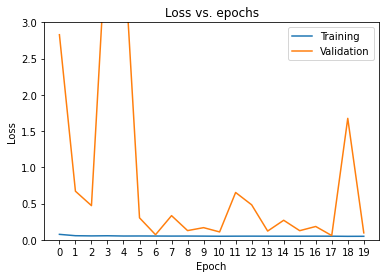

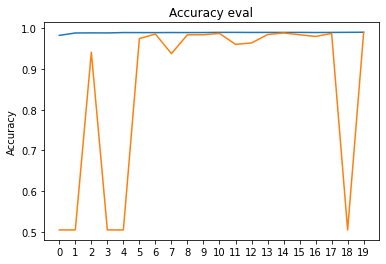

In [8]:
import matplotlib.pyplot as plt
def plot_accuracy(history):
  

  plt.plot(history.history["accuracy"],label='train accuracy')
  plt.plot(history.history["val_accuracy"],label='test accuracy')
  plt.xticks(np.arange(0, 20, 1))
  plt.ylabel("Accuracy")
  # plt.legend(loc = "upper right")
  plt.title("Accuracy eval")
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss vs. epochs')
  plt.ylabel('Loss')
  plt.xticks(np.arange(0, 20, 1))
  plt.ylim(0,3)
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()


plot_loss(hist)
plot_accuracy(hist)

In [ ]:
# 1. 체크포인트들이 있는 폴더 선택
checkPoint_dir = os.path.dirname("/content/drive/MyDrive/Untitled Folder/model_{epoch}.ckpt")

# 2. 해당 폴더에서 가장 마지막 체크포인트 선택
latest = tf.train.latest_checkpoint(checkPoint_dir)

# 3. 해당체크포인트에 저장한 모델의 가중치 불러오기
model.load_weights(latest)


AttributeError: ignored

In [ ]:
model.compile(optimizer ='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.evaluate(x_test, y_test)

125/125 [==============================] - 1s 8ms/step - loss: 0.1768 - accuracy: 0.9883


[0.17683285474777222, 0.9882500171661377]